In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

from fastai import *
from fastai.vision import *

import json

from utils import *
import ast

In [2]:
NUM_SAMPLES_PER_CLASS = 100000
NUM_VAL = 50 * 340

In [3]:
PATH = Path('../data/google_doodle/')

In [4]:
PATH.ls()

[PosixPath('../data/google_doodle/test_simplified.csv'),
 PosixPath('../data/google_doodle/train'),
 PosixPath('../data/google_doodle/sample_submission.csv'),
 PosixPath('../data/google_doodle/csvs'),
 PosixPath('../data/google_doodle/train_csv'),
 PosixPath('../data/google_doodle/test_raw.csv'),
 PosixPath('../data/google_doodle/test')]

### data prep

In [5]:
dfs = []
for p in (PATH/"train").ls():
    print(p)
    sample_df = pd.read_csv(p, usecols=[1,3,5])
    sample_df = sample_df[sample_df.recognized].reset_index(drop=True)[['drawing', 'word']]
    dfs.append(sample_df.sample(min(len(sample_df), NUM_SAMPLES_PER_CLASS)))

../data/google_doodle/train/wine bottle.csv
../data/google_doodle/train/light bulb.csv
../data/google_doodle/train/lightning.csv
../data/google_doodle/train/raccoon.csv
../data/google_doodle/train/ocean.csv
../data/google_doodle/train/tent.csv
../data/google_doodle/train/helmet.csv
../data/google_doodle/train/zebra.csv
../data/google_doodle/train/t-shirt.csv
../data/google_doodle/train/shovel.csv
../data/google_doodle/train/stop sign.csv
../data/google_doodle/train/flamingo.csv
../data/google_doodle/train/cell phone.csv
../data/google_doodle/train/castle.csv
../data/google_doodle/train/campfire.csv
../data/google_doodle/train/shark.csv
../data/google_doodle/train/matches.csv
../data/google_doodle/train/saw.csv
../data/google_doodle/train/owl.csv
../data/google_doodle/train/tooth.csv
../data/google_doodle/train/train.csv
../data/google_doodle/train/parrot.csv
../data/google_doodle/train/carrot.csv
../data/google_doodle/train/picture frame.csv
../data/google_doodle/train/dragon.csv
../da

../data/google_doodle/train/frying pan.csv
../data/google_doodle/train/giraffe.csv
../data/google_doodle/train/ear.csv
../data/google_doodle/train/pig.csv
../data/google_doodle/train/trumpet.csv
../data/google_doodle/train/camel.csv
../data/google_doodle/train/bulldozer.csv
../data/google_doodle/train/book.csv
../data/google_doodle/train/wine glass.csv
../data/google_doodle/train/suitcase.csv
../data/google_doodle/train/octopus.csv
../data/google_doodle/train/blackberry.csv
../data/google_doodle/train/bowtie.csv
../data/google_doodle/train/van.csv
../data/google_doodle/train/grass.csv
../data/google_doodle/train/boomerang.csv
../data/google_doodle/train/donut.csv
../data/google_doodle/train/squiggle.csv
../data/google_doodle/train/triangle.csv
../data/google_doodle/train/bee.csv
../data/google_doodle/train/scorpion.csv
../data/google_doodle/train/crab.csv
../data/google_doodle/train/mug.csv
../data/google_doodle/train/hot air balloon.csv
../data/google_doodle/train/monkey.csv
../data/g

In [6]:
len(dfs)

340

In [7]:
dfs_combined = pd.concat(dfs, axis=0)

In [12]:
dfs_combined.reset_index(drop=True, inplace=True)

In [14]:
dfs_combined.to_csv(PATH/"train/dfs_combined.csv")

###  Create ImageDataBunch using the data block API

In [142]:
bs = 256
sz = 256

In [85]:
test_df = pd.read_csv(PATH/"test_simplified.csv")

In [143]:
def create_func(item):
    arr = list2drawing(ast.literal_eval(item[0]), size=sz, lw=6, time_color=True)
    img = cv2.cvtColor(arr, cv2.COLOR_GRAY2RGB)
    tensor = torch.from_numpy(img)
    return Image(tensor.permute((2,0,1)))

In [144]:
item_list = ItemList.from_df(dfs_combined, col=['drawing', 'word'], create_func=create_func)

In [146]:
idxs = np.arange(item_list.items.shape[0])
np.random.shuffle(idxs)
val_idxs = idxs[:NUM_VAL]
item_lists = item_list.split_by_idx(val_idxs)

In [147]:
label_lists = item_lists.label_from_df(cols=1)

In [148]:
label_lists.train.y

CategoryList (33959415 items)
['wine bottle' 'wine bottle' 'wine bottle' 'wine bottle' ... 'baseball bat' 'baseball bat' 'baseball bat'
 'baseball bat']
Path: .

In [149]:
label_lists.valid.y

CategoryList (17000 items)
['bush' 'vase' 'piano' 'moon' ... 'nose' 'cow' 'bucket' 'moon']
Path: .

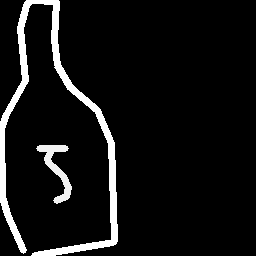

In [150]:
item_list[0]

In [151]:
test_items = ItemList.from_df(test_df, col=['drawing', 'key_id'], create_func=create_func)

In [152]:
label_lists.add_test(test_items);

In [153]:
train_dl = DataLoader(label_lists.train, bs, True, num_workers=8)
valid_dl = DataLoader(label_lists.valid, bs, False, num_workers=8)
test_dl = DataLoader(label_lists.test, bs, False, num_workers=8)

data_bunch = ImageDataBunch(train_dl, valid_dl, test_dl)

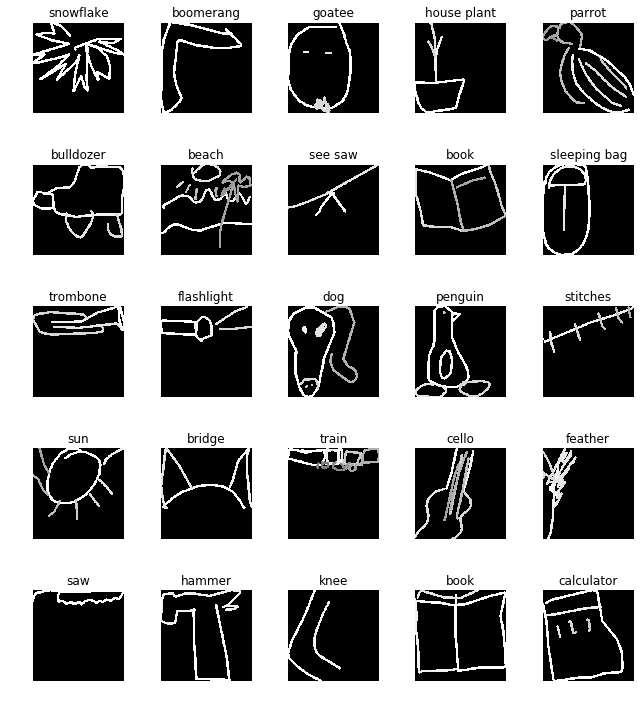

In [156]:
data_bunch.show_batch(5)

### Train

In [157]:
name = f'res34-{sz}'

In [158]:
learn = create_cnn(data_bunch, models.resnet34, metrics=[accuracy, map3])

In [159]:
lr_find(learn)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: thnn_conv2d_forward is not implemented for type torch.ByteTensor

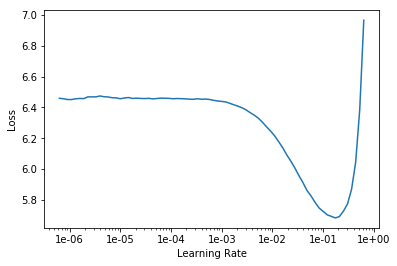

In [16]:
learn.recorder.plot()

In [17]:
learn.fit_one_cycle(1, max_lr=0.1)

Total time: 1:29:02
epoch  train_loss  valid_loss  accuracy  map3    
1      1.710132    1.408104    0.663235  0.739314  (1:29:02)



In [23]:
learn.save(f'{name}-stage-1')

In [24]:
learn.unfreeze()

In [25]:
learn.fit_one_cycle(6, max_lr=6e-4)

Total time: 24:25
epoch  train_loss  valid_loss  accuracy  map3    
1      1.448672    1.383536    0.658706  0.739206  (04:04)
2      1.358841    1.285606    0.681059  0.757471  (04:04)
3      1.165717    1.180751    0.707647  0.780500  (04:04)
4      0.927250    1.081052    0.732294  0.800314  (04:03)
5      0.639683    1.044819    0.744294  0.810804  (04:03)
6      0.454999    1.067124    0.744647  0.810461  (04:03)



In [26]:
learn.save(f'{name}-stage-2')

### Predict

In [27]:
learn.load(f'{name}-stage-2');

In [28]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [31]:
create_submission(preds, data_bunch.test_dl, name)

In [32]:
pd.read_csv(f'subs/{name}.csv.gz').head()

,key_id,word
0,9221337500464606,sock shoe foot
1,9950013608613660,leaf feather stitches
2,9005540600650567,broom paintbrush rake
3,9031090525591545,chair giraffe toilet
4,9896706467105420,flamingo swan bird


In [33]:
# !kaggle competitions submit -c quickdraw-doodle-recognition -f subs/{name}.csv.gz -m "{name}"

100%|██████████████████████████████████████| 1.52M/1.52M [00:17<00:00, 93.0kB/s]
Successfully submitted to Quick, Draw! Doodle Recognition Challenge